# Medtext Classifier Project






## Get data
The authors of the paper have made the data they used for their research available publically. [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

In [ ]:
# Using the 20k dataset
data_dir = r"C:\Users\ainao\OneDrive\Project\Medtext Classifier\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [12]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['C:\\Users\\ainao\\OneDrive\\Project\\Medtext Classifier\\pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'C:\\Users\\ainao\\OneDrive\\Project\\Medtext Classifier\\pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'C:\\Users\\ainao\\OneDrive\\Project\\Medtext Classifier\\pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data



In [13]:
#read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [135]:
len(train_lines)

210040

In [14]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [15]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) 
  abstract_lines = "" 
  abstract_samples = [] 
  
  
  for line in input_lines:
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = "" 
    elif line.isspace(): 
      abstract_line_split = abstract_lines.splitlines() 

      
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} 
        target_text_split = abstract_line.split("\t") 
        line_data["target"] = target_text_split[0] 
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data)
    
    else: 
      abstract_lines += line
  
  return abstract_samples

In [16]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [17]:
# Check the first abstract of our training data
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [18]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [19]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

Sentences with the `OBJECTIVE` label are the least common it seems

How about we check the distribution of our abstract lengths?

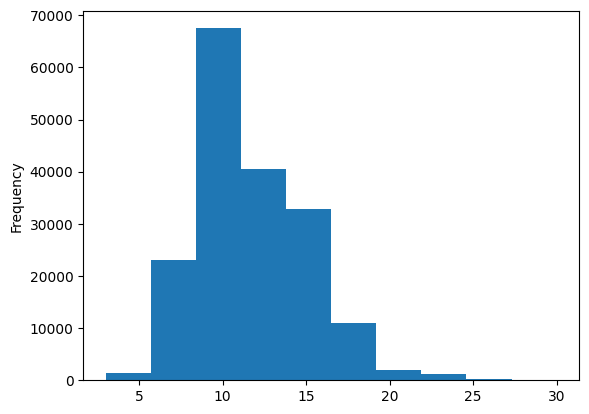

In [20]:
train_df.total_lines.plot.hist();

### Get lists of sentences


In [21]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [22]:
# View first 10 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

create one hot and label encoded labels.


In [23]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))


train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Label encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline Model



In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [27]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [29]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [30]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [31]:
import numpy as np
import tensorflow as tf
from tf_keras import layers
import tf_keras as keras

In [32]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

26.338269273494777

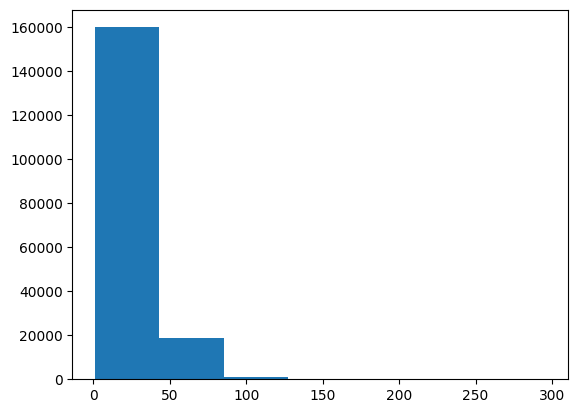

In [33]:
# distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [34]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
# Maximum sentence length in the training set
max(sent_lens)

296

### Create text vectorizer

Now we've got a little more information about our texts, let's create a way to turn it into numbers.

In [36]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [37]:
# Create text vectorizer
from tf_keras.layers import TextVectorization


text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [38]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [39]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the primary analysis will be based on intention-to-treat .

Length of text: 9

Vectorized text:
[[  2  56  85  95  36 261  18 800   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [40]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# text vectorizer config
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding


In [42]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding") 

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the primary analysis will be based on intention-to-treat .

Sentence after vectorization (before embedding):
[[  2  56  85  95  36 261  18 800   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
[[[-0.04007521 -0.02209665 -0.0494214  ...  0.01359576  0.00237957
   -0.01314676]
  [-0.04906914  0.04479053 -0.01535474 ...  0.02487865  0.02428379
    0.02996577]
  [-0.03103076  0.04880085  0.0442853  ... -0.00651174 -0.01979389
    0.01161359]
  ...
  [-0.00833746  0.03749439 -0.01211184 ... -0.01018549  0.0145531
   -0.00237242]
  [-0.00833746  0.03749439 -0.01211184 ... -0.01018549  0.0145531
   -0.00237242]
  [-0.00833746  0.03749439 -0.01211184 ... -0.01018549  0.0145531
   -0.00237242]]]

Embedded sentence shape: (1, 55, 128)


In [43]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [44]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings




In [45]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) 
token_embeddings = token_embed(text_vectors) 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", 
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [51]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), 
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3


562/562 [==============================] - 30s 52ms/step - loss: 0.9142 - accuracy: 0.6377 - val_loss: 0.6890 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.6610 - accuracy: 0.7541 - val_loss: 0.6309 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 28s 51ms/step - loss: 0.6190 - accuracy: 0.7737 - val_loss: 0.5974 - val_accuracy: 0.7812


In [52]:
# Evaluate
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5994 - accuracy: 0.7840


[0.5994316339492798, 0.783993124961853]

In [53]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 5s 5ms/step


array([[4.1290557e-01, 1.9084753e-01, 8.6351112e-02, 2.8371277e-01,
        2.6183031e-02],
       [4.3523103e-01, 3.2522619e-01, 1.0992819e-02, 2.1992923e-01,
        8.6206943e-03],
       [1.6265461e-01, 7.9592904e-03, 2.0612432e-03, 8.2728976e-01,
        3.5125926e-05],
       ...,
       [5.1821225e-06, 8.7487389e-04, 1.2122924e-03, 3.7814129e-06,
        9.9790382e-01],
       [5.2455012e-02, 5.0888538e-01, 8.3975092e-02, 6.0899708e-02,
        2.9378483e-01],
       [2.0498213e-01, 6.4828569e-01, 4.5629032e-02, 4.9454641e-02,
        5.1648527e-02]], dtype=float32)

In [54]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [55]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.39931153184165,
 'precision': 0.7808707730432831,
 'recall': 0.7839931153184165,
 'f1': 0.7814337307590594}

## Model 2: Feature extraction with pretrained token embeddings (USE)

In [47]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

c:\Users\ainao\anaconda3\envs\medtext217\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [48]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
uric acid ( ua ) could act as a natural peroxynitrite scavenger with antioxidant properties .

Sentence after embedding:
[ 0.04321833  0.03581271  0.00015191 -0.04495347  0.07810207  0.0603848
  0.01086588 -0.06425723  0.04761414  0.03883203  0.07062382  0.01384655
 -0.03178465  0.0444885  -0.06532476 -0.07918718  0.0183593  -0.06680601
  0.01731605 -0.010574   -0.06894255 -0.05572343  0.02854285  0.05203873
  0.04936158  0.02285541  0.02165612 -0.01359732  0.04744525  0.01866015] (truncated output)...

Length of sentence embedding:
512


### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [56]:
# Define feature extractor model using TF Hub layer
from tf_keras import layers, Model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
# Get a summary of the model
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [58]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3


562/562 [==============================] - 14s 20ms/step - loss: 0.9176 - accuracy: 0.6511 - val_loss: 0.7957 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7688 - accuracy: 0.7012 - val_loss: 0.7544 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7539 - accuracy: 0.7105 - val_loss: 0.7418 - val_accuracy: 0.7091


In [59]:
# Evaluate 
model_2.evaluate(valid_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.7430 - accuracy: 0.7130


[0.7430052757263184, 0.712961733341217]

In [ ]:
# Make predictions 
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 16s 16ms/step


array([[4.3854210e-01, 3.4732839e-01, 2.2802693e-03, 2.0521133e-01,
        6.6378661e-03],
       [3.2620099e-01, 5.0997686e-01, 3.5398004e-03, 1.5728803e-01,
        2.9944035e-03],
       [2.5128990e-01, 1.4312220e-01, 1.9406747e-02, 5.5183256e-01,
        3.4348521e-02],
       ...,
       [2.0423431e-03, 6.3492875e-03, 5.4703206e-02, 8.4718107e-04,
        9.3605798e-01],
       [4.3347152e-03, 4.5667566e-02, 1.9526660e-01, 1.5694058e-03,
        7.5316179e-01],
       [1.7893462e-01, 2.1689233e-01, 5.2653319e-01, 7.3173339e-03,
        7.0322484e-02]], dtype=float32)

In [61]:
# Convert to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [62]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.29617370581227,
 'precision': 0.7132074768426905,
 'recall': 0.7129617370581226,
 'f1': 0.7098843421155591}

## Model 3: Conv1D with character embeddings



### Creating a character-level tokenizer

In [63]:
# split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'u r i c   a c i d   (   u a   )   c o u l d   a c t   a s   a   n a t u r a l   p e r o x y n i t r i t e   s c a v e n g e r   w i t h   a n t i o x i d a n t   p r o p e r t i e s   .'

In [64]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [65]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

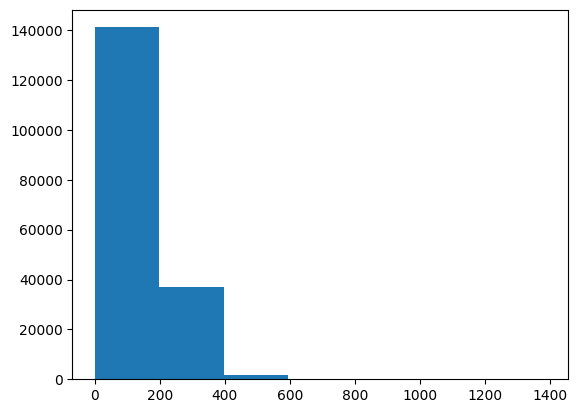

In [66]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [67]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [68]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [ ]:
# character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [71]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
f o r   p a r a c e t a m o l   a n d   g u a i f e n e s i n   ,   t h e   s y r u p   a n d   r e f e r e n c e   p r o d u c t   w e r e   c o n s i d e r e d   t o   b e   b i o e q u i v a l e n t   .

Length of chars: 88

Vectorized chars:
[[17  7  8 14  5  8  5 11  2  3  5 15  7 12  5  6 10 18 16  5  4 17  2  6
   2  9  4  6  3 13  2  9 19  8 16 14  5  6 10  8  2 17  2  8  2  6 11  2
  14  8  7 10 16 11  3 20  2  8  2 11  7  6  9  4 10  2  8  2 10  3  7 22
   2 22  4  7  2 26 16  4 21  5 12  2  6  3  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, 
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
f o r   p a r a c e t a m o l   a n d   g u a i f e n e s i n   ,   t h e   s y r u p   a n d   r e f e r e n c e   p r o d u c t   w e r e   c o n s i d e r e d   t o   b e   b i o e q u i v a l e n t   .

Embedded chars (after vectorization and embedding):
[[[-0.04027439 -0.00025737 -0.02693304 ...  0.04612533 -0.01182825
   -0.00975479]
  [ 0.03998145  0.04271226 -0.0420701  ... -0.0387887   0.02779032
   -0.00024713]
  [-0.01766652  0.0051494  -0.04797248 ... -0.01037265  0.04104009
    0.03972602]
  ...
  [-0.01501827  0.00484624 -0.01500515 ... -0.01021158  0.03743461
   -0.03472705]
  [-0.01501827  0.00484624 -0.01500515 ... -0.01021158  0.03743461
   -0.03472705]
  [-0.01501827  0.00484624 -0.01500515 ... -0.01021158  0.03743461
   -0.03472705]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings



In [73]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [74]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 5

In [75]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [76]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 11ms/step - loss: 1.2550 - accuracy: 0.4880 - val_loss: 1.0365 - val_accuracy: 0.5848
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0070 - accuracy: 0.5945 - val_loss: 0.9408 - val_accuracy: 0.6333
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9300 - accuracy: 0.6366 - val_loss: 0.8712 - val_accuracy: 0.6629


In [77]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8909 - accuracy: 0.6550


[0.8908990025520325, 0.655004620552063]

Nice! Looks like our character-level model is working, let's make some predictions with it and evaluate them.

In [78]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 5s 5ms/step


array([[0.10126819, 0.53670436, 0.05426297, 0.20330194, 0.10446261],
       [0.18468493, 0.5633042 , 0.02613799, 0.16776259, 0.05811025],
       [0.15300398, 0.2428968 , 0.24685816, 0.3117705 , 0.04547054],
       ...,
       [0.01467024, 0.0265979 , 0.13606426, 0.02032502, 0.80234265],
       [0.03665047, 0.14580517, 0.4252677 , 0.04470234, 0.3475743 ],
       [0.3022804 , 0.3689877 , 0.14919992, 0.1482996 , 0.03123238]],
      dtype=float32)

In [79]:
# Convert to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1], dtype=int64)>

In [80]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.50046339202966,
 'precision': 0.647568616531837,
 'recall': 0.6550046339202966,
 'f1': 0.6454041925706947}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [81]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

Woah... There's a lot going on here, let's get a summary and plot our model to visualize what's happening.

In [82]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

In [84]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [85]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [86]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [87]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 48s 78ms/step - loss: 0.9669 - accuracy: 0.6147 - val_loss: 0.7837 - val_accuracy: 0.6955
Epoch 2/3
562/562 [==============================] - 43s 76ms/step - loss: 0.7944 - accuracy: 0.6916 - val_loss: 0.7133 - val_accuracy: 0.7307
Epoch 3/3
562/562 [==============================] - 40s 71ms/step - loss: 0.7679 - accuracy: 0.7052 - val_loss: 0.6873 - val_accuracy: 0.7407


In [88]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 32s 34ms/step - loss: 0.6908 - accuracy: 0.7337


[0.6908054351806641, 0.7336819767951965]

Nice! Our token-character hybrid model has come to life!

To make predictions with it, since it takes multiplie inputs, we can pass the `predict()` method a tuple of token-level sequences and character-level sequences.

We can then evaluate the predictions as we've done before.

In [89]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 34s 33ms/step


array([[4.6662349e-01, 3.1070739e-01, 3.6786580e-03, 2.1023139e-01,
        8.7591037e-03],
       [4.3879136e-01, 3.3979806e-01, 2.4815509e-03, 2.1788032e-01,
        1.0487778e-03],
       [3.1464049e-01, 2.1003282e-01, 6.1910834e-02, 3.4694561e-01,
        6.6470265e-02],
       ...,
       [4.5353471e-04, 6.7045889e-03, 4.8875216e-02, 1.0495310e-04,
        9.4386172e-01],
       [5.0831274e-03, 3.3396259e-02, 2.2272417e-01, 1.8066121e-03,
        7.3698986e-01],
       [2.4903791e-01, 5.0486267e-01, 1.8403029e-01, 2.8373443e-02,
        3.3695776e-02]], dtype=float32)

In [90]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [ ]:
# results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.36819806699324,
 'precision': 0.7333051540757313,
 'recall': 0.7336819806699325,
 'f1': 0.731480421072688}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [93]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

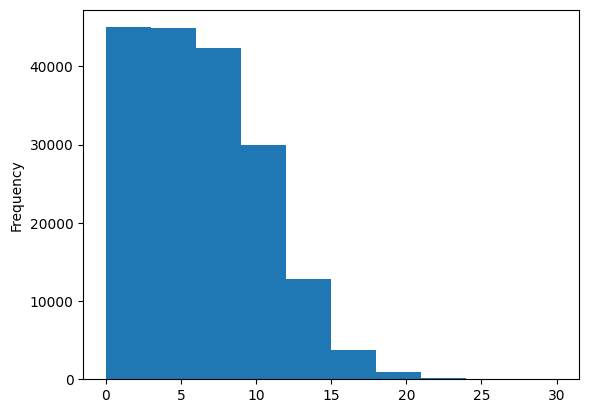

In [94]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Looking at the distribution of the `"line_number"` column, it looks like the majority of lines have a position of 15 or less.

In [95]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [96]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [97]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

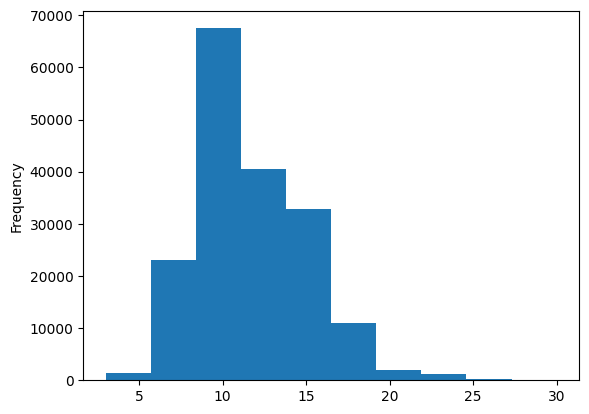

In [98]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

In [99]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [100]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

In [101]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [102]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

In [103]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [104]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<tf_keras.src.engine.input_layer.InputLayer object at 0x000001FDE6E38080> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x000001FE911DBF80> True
<tf_keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x000001FDF55A4140> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x000001FDC73B7B00> False
<tf_keras.src.layers.core.embedding.Embedding object at 0x000001FDF54BA000> True
<tf_keras.src.layers.core.dense.Dense object at 0x000001FDE7FAC740> True
<tf_keras.src.layers.rnn.bidirectional.Bidirectional object at 0x000001FE912E5160> True
<tf_keras.src.layers.merging.concatenate.Concatenate object at 0x000001FE87A4E0F0> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x000001FDF5592600> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x000001FE87A4DCA0> True
<tf_keras.src.layers.core.dense.Dense object at 0x000001FE9126DA00> True
<tf_keras.src.layers.core.dense.Dense object at 0x000001FE912A2F30> True
<tf_keras.src.layers.core.

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_total_lines_one_hot, 
                                                                train_sentences, 
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) 
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [107]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 56s 82ms/step - loss: 1.1053 - accuracy: 0.7140 - val_loss: 0.9853 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 41s 73ms/step - loss: 0.9685 - accuracy: 0.8138 - val_loss: 0.9511 - val_accuracy: 0.8248
Epoch 3/3
562/562 [==============================] - 41s 73ms/step - loss: 0.9495 - accuracy: 0.8235 - val_loss: 0.9405 - val_accuracy: 0.8281


Tribrid model trained! Time to make some predictions with it and evaluate them just as we've done before.

In [108]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 33s 34ms/step


array([[0.46608526, 0.12230306, 0.01288345, 0.37994248, 0.01878576],
       [0.49758184, 0.12437864, 0.06951939, 0.29533973, 0.01318038],
       [0.27761477, 0.11537529, 0.15289497, 0.39122936, 0.0628856 ],
       ...,
       [0.0300394 , 0.10242257, 0.04074027, 0.02808039, 0.7987173 ],
       [0.02998965, 0.29155326, 0.11241356, 0.0286981 , 0.5373454 ],
       [0.22519127, 0.5549594 , 0.10538028, 0.05137455, 0.06309449]],
      dtype=float32)

In [109]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [110]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.00344234079174,
 'precision': 0.8289649246506129,
 'recall': 0.8300344234079173,
 'f1': 0.8290886133178169}

## Model 6: Transfer Learning with pretrained bert + character embeddings + positional embeddings

In [ ]:
import numpy as np
import tensorflow as tf
import tf_keras as keras
from tf_keras import layers
from transformers import AutoTokenizer, TFBertModel


MODEL_NAME = "bert-base-uncased"
SEQ_LEN = 128
BERT_TRAINABLE = False 

# Tokenizer and Bert

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
bert_backbone = TFBertModel.from_pretrained(
    MODEL_NAME,
    from_pt=False,
    use_safetensors=False,
    output_hidden_states=False,
    output_attentions=False,
)
bert_backbone.trainable = BERT_TRAINABLE  

# Tokenization helpers (NumPy side)
def _tokenize_np(texts_np):
    """
    texts_np: np.ndarray of shape [B] (dtype bytes/str/object)
    returns: (input_ids[int32 BxL], attention_mask[int32 BxL])
    """
    if isinstance(texts_np, np.ndarray):
        texts_list = []
        for t in texts_np.tolist():
            if isinstance(t, (bytes, bytearray)):
                texts_list.append(t.decode("utf-8", errors="ignore"))
            else:
                texts_list.append(str(t))
    else:
        texts_list = [str(texts_np)]

    enc = tokenizer(
        texts_list,
        padding="max_length",
        truncation=True,
        max_length=SEQ_LEN,
        return_tensors="np",
    )
    return enc["input_ids"].astype(np.int32), enc["attention_mask"].astype(np.int32)

def _hf_tokenize_layer(text_tensor):
    """text_tensor: tf.string [B]  ->  ids[int32 BxL], mask[int32 BxL]"""
    input_ids, attention = tf.numpy_function(
        func=_tokenize_np,
        inp=[text_tensor],
        Tout=(tf.int32, tf.int32),
    )
    input_ids.set_shape([None, SEQ_LEN])
    attention.set_shape([None, SEQ_LEN])
    return input_ids, attention

def _squeeze_if_needed(x):
    return tf.squeeze(x, axis=-1) if x.shape.rank == 2 else x



c:\Users\ainao\anaconda3\envs\medtext217\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassi

In [ ]:
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_inputs")
token_text   = layers.Lambda(_squeeze_if_needed, name="maybe_squeeze")(token_inputs)

input_ids, attention_mask = layers.Lambda(_hf_tokenize_layer, name="bert_tokenize")(token_text)
bert_outputs = bert_backbone(input_ids=input_ids, attention_mask=attention_mask)
bert_pooled  = layers.Lambda(lambda o: o.pooler_output, name="bert_pooled")(bert_outputs)

# Project pooled BERT into your expected 128-dim token embedding
token_outputs = layers.Dense(128, activation="relu", name="token_projection")(bert_pooled)
token_model = keras.Model(inputs=token_inputs, outputs=token_outputs, name="token_bert_path")


# char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)          
char_embeddings = char_embed(char_vectors)          
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = keras.Model(inputs=char_inputs, outputs=char_bi_lstm, name="char_path")


# line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = keras.Model(inputs=line_number_inputs, outputs=x, name="line_number_path")

# total lines input
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = keras.Model(inputs=total_lines_inputs, outputs=y, name="total_lines_path")

# 5) Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")(
    [token_model.output, char_model.output]
)
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Add positional features

z = layers.Concatenate(name="token_char_positional_embedding")(
    [line_number_model.output, total_line_model.output, z]
)


# 7) Output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)


# Final model 
model_6 = keras.Model(
    inputs=[
        line_number_model.input,
        total_line_model.input,
        token_model.input,
        char_model.input,
    ],
    outputs=output_layer,
    name="tribrid_bert_classifier",
)



In [113]:
model_6.summary()

Model: "tribrid_bert_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 maybe_squeeze (Lambda)      (None,)                      0         ['token_inputs[0][0]']        
                                                                                                  
 bert_tokenize (Lambda)      ((None, 128),                0         ['maybe_squeeze[0][0]']       
                              (None, 128))                                                        
                                                                                                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []      

In [ ]:
model_6.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=["accuracy"],
)

In [ ]:
# Fit the token bert, char and positional embedding model
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 2081s 4s/step - loss: 0.8683 - accuracy: 0.6583 - val_loss: 0.5216 - val_accuracy: 0.8112
Epoch 2/3
562/562 [==============================] - 2320s 4s/step - loss: 0.5560 - accuracy: 0.7908 - val_loss: 0.4969 - val_accuracy: 0.8142
Epoch 3/3
562/562 [==============================] - 2105s 4s/step - loss: 0.5152 - accuracy: 0.8018 - val_loss: 0.4472 - val_accuracy: 0.8354


In [116]:
# Make predictions with bert-char-positional hybrid model
model_6_pred_probs = model_6.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 2743s 3s/step


array([[0.46608526, 0.12230306, 0.01288345, 0.37994248, 0.01878576],
       [0.49758184, 0.12437864, 0.06951939, 0.29533973, 0.01318038],
       [0.27761477, 0.11537529, 0.15289497, 0.39122936, 0.0628856 ],
       ...,
       [0.0300394 , 0.10242257, 0.04074027, 0.02808039, 0.7987173 ],
       [0.02998965, 0.29155326, 0.11241356, 0.0286981 , 0.5373454 ],
       [0.22519127, 0.5549594 , 0.10538028, 0.05137455, 0.06309449]],
      dtype=float32)

In [117]:
# Turn prediction probabilities into prediction classes
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 4, 1], dtype=int64)>

In [118]:
# Calculate results of bert-char-positional hybrid model
model_6_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 83.47345425658679,
 'precision': 0.8342304525380403,
 'recall': 0.8347345425658679,
 'f1': 0.8343897876188557}

## Compare model results

In [121]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results,
                                  "tribrid_bert_classifier": model_6_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.399312,0.780871,0.783993,0.781434
pretrained_token_embed,71.296174,0.713207,0.712962,0.709884
custom_char_embed_conv1d,65.500463,0.647569,0.655005,0.645404
hybrid_char_token_embed,73.368198,0.733305,0.733682,0.731480
tribrid_pos_char_token_embed,83.003442,0.828965,0.830034,0.829089
tribrid_bert_classifier,83.473454,0.834230,0.834735,0.834390


In [122]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

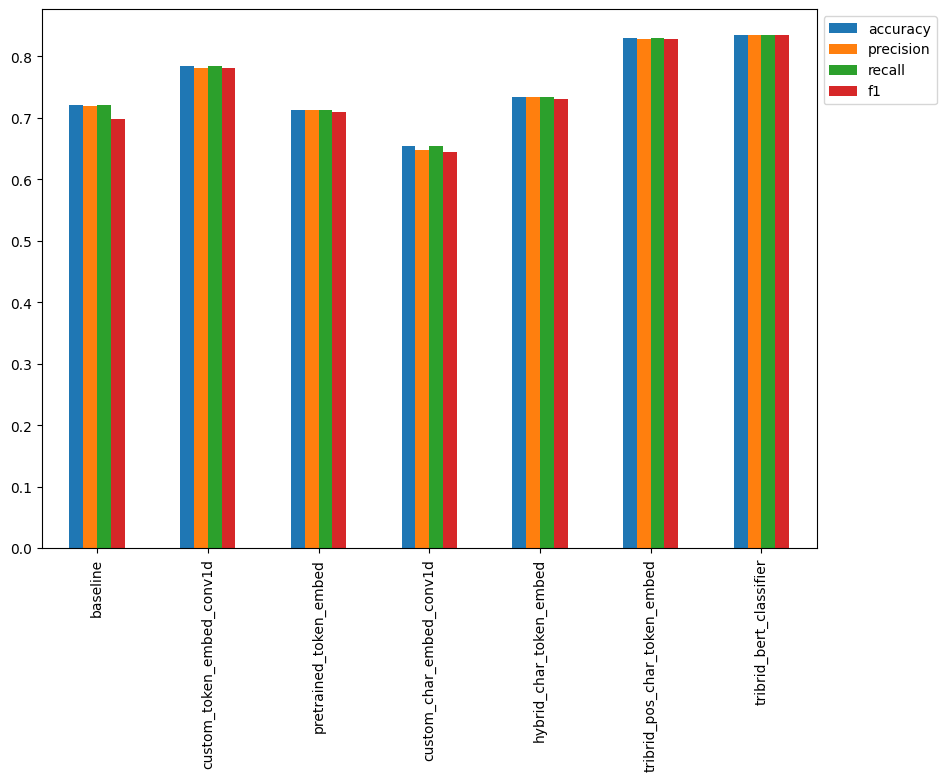

In [123]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

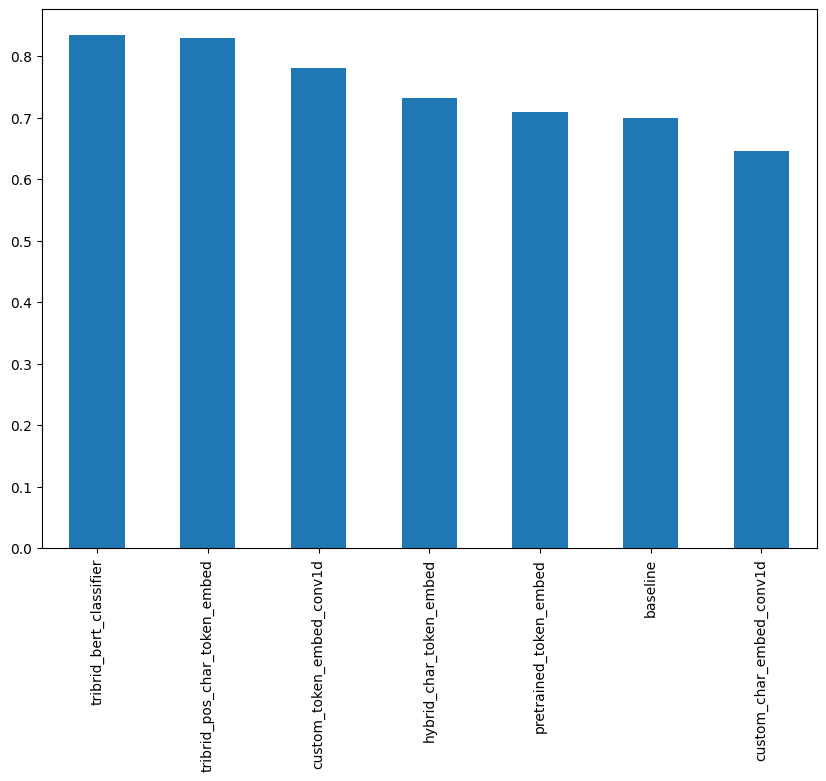

In [124]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [127]:
model_6.save("save_model")

INFO:tensorflow:Assets written to: save_model\assets


INFO:tensorflow:Assets written to: save_model\assets


In [134]:
len(train_df), len(test_df), len(val_df)

(180040, 30135, 30212)